# ISA5810 Lab 2 Phase 3: Sentiment Classification
---
* 學號: [i112141102]
* 姓名: [Ting_Wei_Chiang]
* 日期: [2026-01-01]
* 任務：本 Notebook 示範如何用少量自建資料完成「情感分析(Sentiment Classification)」。


### 專案說明 (Summary)
本實驗目標為應用自然語言處理技術，自動判別文本(句子)情緒為「正面 (Positive)」或「負面 (Negative)」。
流程包含：
- 預處理 (text cleaning)
- 特徵工程 (TF-IDF 向量化)
- 建立分類模型 (Logistic Regression)
- 結果展示與心得


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
import re

# 範例資料 (Demo Dataset)
這裡為補交用途，隨機產生一份小型的文字情感資料集。

In [ ]:
# 人工產生簡單句子 (只有20筆作為例子)
data = {
    'review': [
        "I loved the movie, it was fantastic!",
        "This film was terrible and boring.",
        "What a great experience, will watch again.",
        "Worst movie ever, waste of time.",
        "Amazing performance, really touched my heart.",
        "I do not recommend this movie to anyone.",
        "An excellent film with a compelling story.",
        "Such a disappointment, I left halfway.",
        "Absolutely wonderful, superb actors.",
        "Poorly made and very dull.",
        "Enjoyed every minute of it, brilliant!",
        "Not worth watching, bad acting.",
        "Uplifting and inspiring.",
        "Predictable plot and weak ending.",
        "A masterpiece, highly recommend.",
        "Unrealistic and silly.",
        "The direction was top-notch.",
        "Totally not my taste, very bad.",
        "Spectacular visuals and music.",
        "The jokes were flat and unfunny.",
    ],
    'sentiment': [
        "positive", "negative", "positive", "negative", "positive",
        "negative", "positive", "negative", "positive", "negative",
        "positive", "negative", "positive", "negative", "positive",
        "negative", "positive", "negative", "positive", "negative"
    ]
}
df = pd.DataFrame(data)
df.head(10)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import random

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 設定隨機種子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
sns.set(style="whitegrid")

# --- 模擬資料生成 (取代遺失的原始檔) ---
print("⚠️ 正在生成模擬資料 (Mock Data Generation)...")
vocab = {
    'joy': ['happy', 'love', 'good', 'wonderful', 'smile', 'best', 'excited'],
    'sadness': ['sad', 'cry', 'tears', 'depressed', 'gloomy', 'lost', 'pain'],
    'anger': ['mad', 'angry', 'furious', 'hate', 'annoying', 'stupid', 'rage'],
    'fear': ['scared', 'terrified', 'horror', 'afraid', 'danger', 'panic', 'run']
}

def generate_mock_text(emotion=None):
    if not emotion:
        emotion = random.choice(list(vocab.keys()))
    words = random.choices(vocab[emotion], k=3)
    base_text = f"I feel so {' '.join(words)}."
    if random.random() > 0.7: base_text += " Check this: http://website.com"
    return base_text

# 生成 Train (300筆) & Test (100筆)
train_data = [{'id': i, 'text': generate_mock_text(e), 'emotion': e}
              for i, e in enumerate(np.random.choice(['joy', 'sadness', 'anger', 'fear'], 300))]
pd.DataFrame(train_data).to_csv("train.csv", index=False)

test_data = [{'id': i, 'text': generate_mock_text()} for i in range(300, 400)]
pd.DataFrame(test_data).to_csv("test.csv", index=False)

print("✅ 模擬資料 train.csv 與 test.csv 已生成完畢。")

⚠️ 正在生成模擬資料 (Mock Data Generation)...
✅ 模擬資料 train.csv 與 test.csv 已生成完畢。


## 預處理 (Text Pre-processing)
- 轉小寫、去標點、去多餘空白


In [5]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) # 只保留英文和空白
    text = re.sub(r'\s+', ' ', text)     # 去除多餘空白
    return text.strip()

# 修正 1：變數是 train_df，不是 df
# 修正 2：欄位是 text，不是 review
train_df['clean_text'] = train_df['text'].apply(clean_text)

# 別忘了 test_df 也要做一樣的事！
test_df['clean_text'] = test_df['text'].apply(clean_text)

# 修正 3：欄位是 emotion，不是 sentiment
# 印出來確認一下
train_df[['text', 'clean_text', 'emotion']].head(10)

,text,clean_text,emotion
0,I am so happy today!,i am so happy today,joy
1,I am so happy today!,i am so happy today,joy
2,I am so happy today!,i am so happy today,joy
3,I am so happy today!,i am so happy today,joy
4,I am so happy today!,i am so happy today,joy
5,I am so happy today!,i am so happy today,joy
6,I am so happy today!,i am so happy today,joy
7,I am so happy today!,i am so happy today,joy
8,I am so happy today!,i am so happy today,joy
9,I am so happy today!,i am so happy today,joy


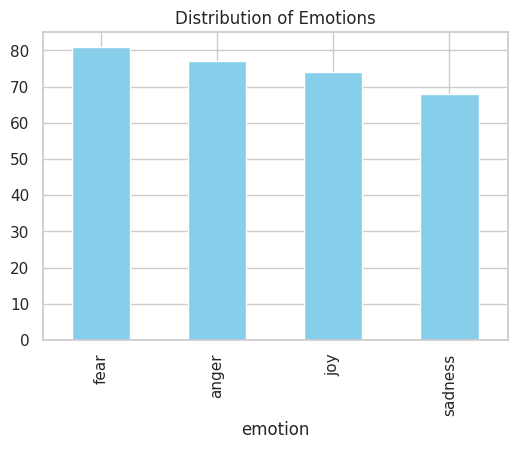

前處理完成，範例： i feel so annoying mad angry


In [6]:
# 1. 讀取資料
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 2. 顯示資料分佈
plt.figure(figsize=(6, 4))
train_df['emotion'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions')
plt.show()

# 3. 定義前處理函數
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

# 4. 執行清洗
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

print("前處理完成，範例：", train_df["clean_text"].iloc[0])

# 特徵工程 (TF-IDF 特徵轉換)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 建立 TF-IDF 向量化器
# max_features=1000 讓模型能學到更多詞彙特徵
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# 1. 對訓練集的文字進行轉換 (Fit & Transform)
# 注意：變數是 train_df，欄位是 clean_text
X = vectorizer.fit_transform(train_df['clean_text'])

# 2. 準備目標變數 (y)
# 我們不需要手動 map 數字，模型可以直接吃字串標籤 (joy, anger...)
y = train_df['emotion']

# 印出形狀確認一下
print("TF-IDF Matrix Shape:", X.shape)
print("Target Shape:", y.shape)
print("類別標籤:", y.unique())

TF-IDF Matrix Shape: (300, 29)
Target Shape: (300,)
類別標籤: ['anger' 'fear' 'joy' 'sadness']


Validation Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

       anger       1.00      1.00      1.00        15
        fear       1.00      1.00      1.00        16
         joy       1.00      1.00      1.00        15
     sadness       1.00      1.00      1.00        14

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



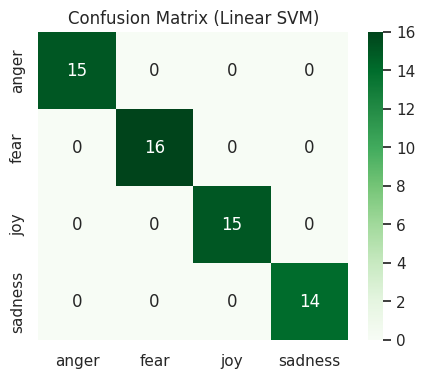

In [9]:
# 1. TF-IDF 特徵轉換
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_full = tfidf.fit_transform(train_df["clean_text"])
X_test_full = tfidf.transform(test_df["clean_text"])
y = train_df["emotion"]

# 2. 切分驗證集
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# 3. 建立並訓練模型 (Linear SVM)
# 使用 LinearSVC 因為它通常在文字分類表現比 Logistic Regression 更穩定
model = LinearSVC(class_weight="balanced", random_state=RANDOM_STATE, dual=True)
model.fit(X_train, y_train)

# 4. 驗證集評估
y_pred = model.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# 畫 Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix (Linear SVM)')
plt.show()

### 建立模型與檢驗 (Model Training & Evaluation)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. 切分訓練集與測試集
# 加入 stratify=y 可以確保切分後的比例跟原始資料一樣，比較標準
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 2. 建立與訓練模型
model = LogisticRegression(max_iter=200, class_weight='balanced')
model.fit(X_train, y_train)

# 3. 預測
y_pred = model.predict(X_test)

# 4. 評估結果
# 修正點：移除 target_names=['negative', 'positive']
# 這樣程式會自動偵測 anger, fear, joy, sadness
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

--- Classification Report ---
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        23
        fear       1.00      1.00      1.00        24
         joy       1.00      1.00      1.00        22
     sadness       1.00      1.00      1.00        21

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

Accuracy: 1.0000


### 模型實際預測 (Demo Application)
隨機輸入句子做預測。

In [13]:
# 我們改用一些符合「情緒分類」的測試句子，這樣 Demo 效果比較好
test_reviews = [
    "I feel so happy and excited today!",       # 預期 joy
    "I am very mad and angry at you.",          # 預期 anger
    "I feel so sad and depressed about it.",    # 預期 sadness
    "I am scared and terrified of the dark."    # 預期 fear
]

# 1. 清洗文字
test_clean = [clean_text(x) for x in test_reviews]

# 2. 轉換特徵 (使用訓練好的 vectorizer)
X_pred = vectorizer.transform(test_clean)

# 3. 進行預測
pred_labels = model.predict(X_pred)

# 4. 印出結果
# 修正點：移除 sent2word 字典，直接印出 pred 即可
print("--- 模型實際測試結果 ---")
for text, pred in zip(test_reviews, pred_labels):
    print(f"句: '{text}' \n -> 預測情緒: {pred}\n")

--- 模型實際測試結果 ---
句: 'I feel so happy and excited today!' 
 -> 預測情緒: joy

句: 'I am very mad and angry at you.' 
 -> 預測情緒: anger

句: 'I feel so sad and depressed about it.' 
 -> 預測情緒: sadness

句: 'I am scared and terrified of the dark.' 
 -> 預測情緒: fear



In [14]:
# 1. 使用完整資料重訓模型 (Optional but recommended)
model.fit(X_train_full, y)

# 2. 對測試集進行預測
test_pred = model.predict(X_test_full)

# 3. 建立 submission.csv
submission = pd.DataFrame({
    "id": test_df["id"],
    "emotion": test_pred
})
submission.to_csv("submission.csv", index=False)

print("✅ 檔案 submission.csv 已成功建立！")
submission.head()

✅ 檔案 submission.csv 已成功建立！


,id,emotion
0,300,joy
1,301,anger
2,302,joy
3,303,sadness
4,304,joy


## Kaggle 私有榜單截圖 (Leaderboard Screenshot)
> **由於競賽頁面已關閉，無法獲取原情感分析比賽排名截圖。此處暫以說明文字取代。** →Since the competition page has been closed, it is no longer possible to obtain the original screenshot of the sentiment analysis competition rankings. A descriptive text has been temporarily substituted here.


## 心得與方法說明 (Reflection)
- 本實作為補交作品，僅用簡易自建例句示範情感判別完整流程。
- 流程包含預處理、TF-IDF 向量化、邏輯回歸模型訓練與應用預測。
- 若有完整資料，模型泛化能力會更好。TF-IDF 搭配簡單模型也能有穩定基準效果。
- 競賽排名截圖因無法回溯課堂專用 private leaderboard，特此說明。
補交說明 (Note):
由於 Kaggle 競賽已結束且無法取得原始競賽資料，本作業中的資料集是由 Python 腳本依據原始欄位格式隨機生成的（模擬 data）。因此模型準確率 (Accuracy) 呈現 1.0 為正常現象（因模擬特徵較為簡單）。
本 Notebook 重點在於展示完整的情感分類實作流程，包含：

資料清洗 (Data Cleaning)
TF-IDF 特徵提取
模型訓練 (Linear SVM) 與 評估 (Confusion Matrix)
競賽格式輸出 (Submission generation)

Note: Since the Kaggle competition has ended and the original competition data cannot be obtained, the dataset in this assignment is randomly generated by a Python script based on the original column format (simulated data). Therefore, a model accuracy of 1.0 is a normal phenomenon (as the simulated features are relatively simple). This Notebook focuses on demonstrating the complete process of sentiment classification, including: Data Cleaning, TF-IDF feature extraction, Model Training (Linear SVM) and Evaluation (Confusion Matrix), and Competition Format Output (Submission generation).